In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


# **Loading data**

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
train_df.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


We can now see how is our training data structured, we have 22 columns, where the first one is the id and the last one is the FloodProbability which will be the value we are trying to predict. The rest will be our features, we can see the data is all in integers and there are no Null values which means we don't have to do much data cleaning.

## **Data Analysis**

### Summary of the dataset

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

### Statistical analysis of the dataset

<Axes: >

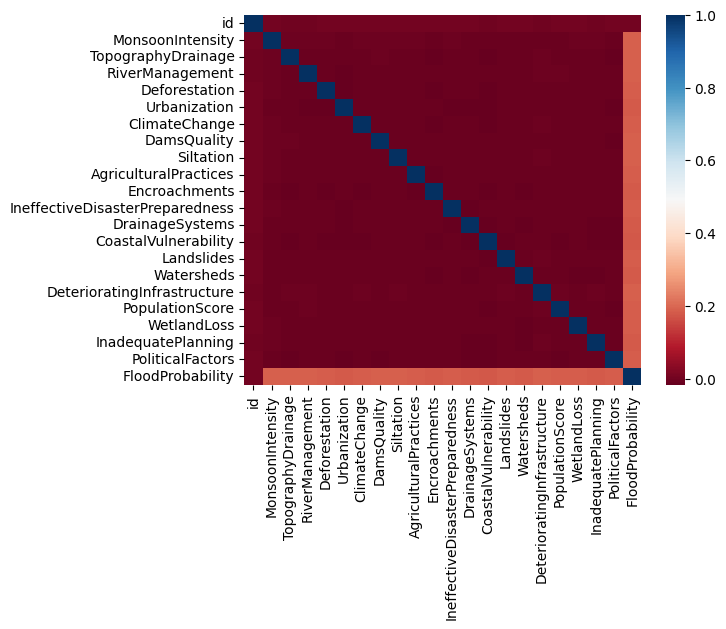

In [4]:
corr = train_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

If you plot the correlation matrix of the features, you can see there are no features that are highly correlated which means we won't have to remove any features. Next we are going to check the mean and standard deviation of each column, we would remove any row where there is a value with more than 3 standard deviation difference with the mean, to get rid of outliers. In this case there aren't any clear outliers.

In [5]:
desc_df = train_df.describe()
desc_df

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>],
       [<Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>],
       [<Axes: title={'center': 'Urbanization'}>,
        <Axes: title={'center': 'ClimateChange'}>],
       [<Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>],
       [<Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>],
       [<Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>],
       [<Axes: title={'center': 'Watersheds'}>,
        <Axes: title={'center': 'DeterioratingInfrastructure'}>],
       [<Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>],
       [<Axes: title={'cent

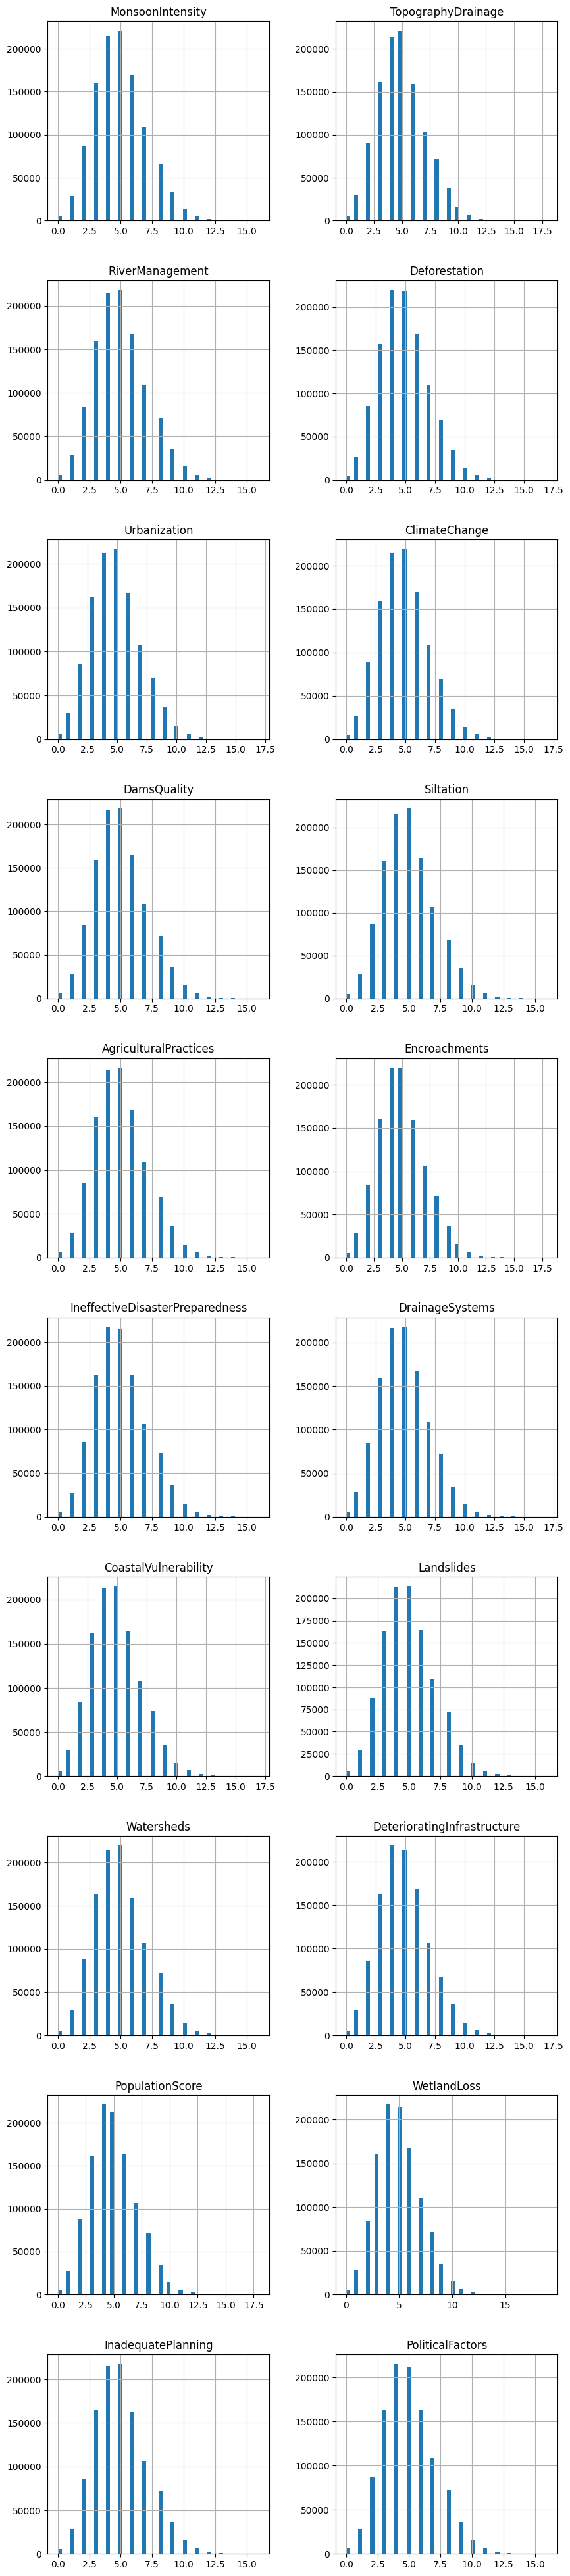

In [6]:
numerical_columns = train_df.columns[1:21]
train_df.hist(column=numerical_columns, bins=50, layout=(10,2), figsize=(10,50))

array([[<Axes: title={'center': 'FloodProbability'}>]], dtype=object)

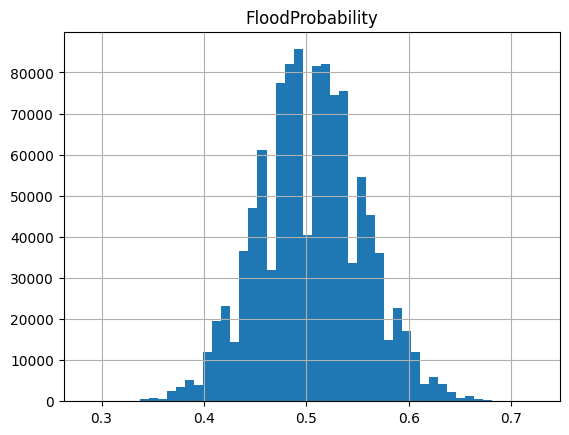

In [7]:
target = train_df.columns[-1]
train_df.hist(column=target, bins=50)

## **Linear Models**

In [8]:
def train_valid_split(df):
    y = df['FloodProbability']
    X = df.drop(labels='FloodProbability', axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_valid, y_train, y_valid

In [9]:
X_train, X_valid, y_train, y_valid = train_valid_split(train_df)

linear_regressor = make_pipeline(StandardScaler(),
                                 LinearRegression())

linear_regressor.fit(X_train, y_train)
linear_regression_score = linear_regressor.score(X_valid, y_valid)
print('Linear regression R2 score: ',linear_regression_score)

ridge_regressor =make_pipeline(StandardScaler(),
                               Ridge())

ridge_regressor.fit(X_train, y_train)
ridge_regression_score = ridge_regressor.score(X_valid, y_valid)
print('Ridge regression R2 score: ',ridge_regression_score)

Linear regression R2 score:  0.844872190674534
Ridge regression R2 score:  0.844872190302794


## **Advanced Models**

In [10]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

In [11]:
xgb_params = {
            'colsample_bytree': 1.0,
            'max_depth': 3,
            'min_child_weight': 1.2,
            'n_estimators': 500}

xgb_basic = xgb.XGBRegressor(**xgb_params)
xgb_basic.fit(X_train, y_train)

y_pred = xgb_basic.predict(X_valid)
xgb_basic_score = r2_score(y_valid, y_pred)
print('XGBoost R2 score: ', xgb_basic_score)

XGBoost R2 score:  0.836307074970052


In [12]:
catboost_basic = cat.CatBoostRegressor(verbose=False)
catboost_basic.fit(X_train, y_train)

y_pred = catboost_basic.predict(X_valid)
catboost_basic_score = r2_score(y_valid, y_pred)
print('CatBoost R2 score: ', catboost_basic_score)

CatBoost R2 score:  0.8461236085877089


In [13]:
lgbm_basic = lgb.LGBMRegressor(verbose=-1)
lgbm_basic.fit(X_train, y_train)

y_pred = lgbm_basic.predict(X_valid)
lgbm_basic_score = r2_score(y_valid, y_pred)
print('CatBoost R2 score: ', lgbm_basic_score)

CatBoost R2 score:  0.766238121953043


## **Feature Engineering**

In [14]:
def f_engineering(data):
    numerical_columns = data.columns[1:21]
    
    print('Computing sum....')
    data['sum'] = data[numerical_columns].sum(axis=1)
    data['sum_72_76'] = data['sum'].isin(np.arange(72, 76))
    
    return data

In [15]:
def full_f_engineering(data):
    numerical_columns = data.columns[1:21]
    
    data['ClimateAnthropogenicInteraction'] = (data['MonsoonIntensity'] + data['ClimateChange']) * (data['Deforestation'] + data['Urbanization'] + data['AgriculturalPractices'] + data['Encroachments'])
    data['InfrastructurePreventionInteraction'] = (data['DamsQuality'] + data['DrainageSystems'] + data['DeterioratingInfrastructure']) * (data['RiverManagement'] + data['IneffectiveDisasterPreparedness'] + data['InadequatePlanning'])
    print('Computing sum....')
    data['sum'] = data[numerical_columns].sum(axis=1)
    print('Computing standard deviation....')
    data['std'] = data[numerical_columns].std(axis=1)
    print('Computing mean....')
    data['mean'] = data[numerical_columns].mean(axis=1)
    print('Computing max....')
    data['max'] = data[numerical_columns].max(axis=1)
    print('Computing min....')
    data['min'] = data[numerical_columns].min(axis=1)
    print('Computing median....')
    data['median'] = data[numerical_columns].median(axis=1)
    data['q_25'] = data[numerical_columns].quantile(0.25, axis=1)
    data['q_75'] = data[numerical_columns].quantile(0.75, axis=1)
    data['skew'] = data[numerical_columns].skew(axis=1)
    data['kurt'] = data[numerical_columns].kurt(axis=1)
    data['sum_72_76'] = data['sum'].isin(np.arange(72, 76))
    print('Computing harmonic mean....')
    data['harmonic'] = len(numerical_columns) / data[numerical_columns].apply(lambda x: (1/x).mean(), axis=1)
    print('Computing geometric mean....')
    data['geometric'] = data[numerical_columns].apply(lambda x: x.prod()**(1/len(x)), axis=1)
    print('Computing zscore....')
    data['zscore'] = data[numerical_columns].apply(lambda x: (x - x.mean()) / x.std(), axis=1).mean(axis=1)
    data['cv'] = data['std'] / data['mean']
    data['Skewness_75'] = (data[numerical_columns].quantile(0.75, axis=1) - data[numerical_columns].mean(axis=1)) / data[numerical_columns].std(axis=1)
    data['Skewness_25'] = (data[numerical_columns].quantile(0.25, axis=1) - data[numerical_columns].mean(axis=1)) / data[numerical_columns].std(axis=1)
    print('Computing 2nd moment....')
    data['2ndMoment'] = data[numerical_columns].apply(lambda x: (x**2).mean(), axis=1)
    print('Computing 3rd moment....')
    data['3rdMoment'] = data[numerical_columns].apply(lambda x: (x**3).mean(), axis=1)
    print('Computing entropy....')
    data['entropy'] = data[numerical_columns].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)
    
    return data

In [16]:
train_df_fe = f_engineering(train_df)
X_train_fe, X_valid_fe, y_train, y_valid = train_valid_split(train_df_fe)

Computing sum....


In [17]:
linear_regressor = make_pipeline(StandardScaler(),
                                 LinearRegression())

linear_regressor.fit(X_train_fe, y_train)
linear_regression_sum_score = linear_regressor.score(X_valid_fe, y_valid)
print('Linear regression with sum R2 score: ',linear_regression_sum_score)

Linear regression with sum R2 score:  0.8512533410964446


In [18]:
catboost_basic = cat.CatBoostRegressor(verbose=False)
catboost_basic.fit(X_train_fe, y_train)

y_pred = catboost_basic.predict(X_valid_fe)
catboost_sum_score = r2_score(y_valid, y_pred)
print('CatBoost R2 score: ', catboost_sum_score)

CatBoost R2 score:  0.8674308678113508


In [19]:
train_df_full_fe = full_f_engineering(train_df)
X_train_full, X_valid_full, y_train, y_valid = train_valid_split(train_df_full_fe)

Computing sum....
Computing standard deviation....
Computing mean....
Computing max....
Computing min....
Computing median....
Computing harmonic mean....
Computing geometric mean....
Computing zscore....
Computing 2nd moment....
Computing 3rd moment....
Computing entropy....


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_full, y_train)
linear_regression_full_score = linear_regressor.score(X_valid_full, y_valid)
print('Linear regression with sum R2 score: ',linear_regression_full_score)

Linear regression with sum R2 score:  0.8520425077878315


In [21]:
catboost_basic = cat.CatBoostRegressor(verbose=False)
catboost_basic.fit(X_train_full, y_train)

y_pred = catboost_basic.predict(X_valid_full)
catboost_full_score = r2_score(y_valid, y_pred)
print('CatBoost R2 score: ', catboost_full_score)

CatBoost R2 score:  0.868797948459571


## **Hyperparameter tuning Catboost**

In [22]:
import optuna

In [23]:
def objective(trial):
    params = {
        'iterations':1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    model = cat.CatBoostRegressor(**params, silent=True)
    model.fit(X_train_full, y_train)
    predictions = model.predict(X_valid_full)
    r2 = r2_score(y_valid, predictions)
    
    return r2

In [24]:
#Not run
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=30)

In [25]:
best_params_cat = {'learning_rate': 0.05414716347485471, 
                   'depth': 8, 
                   'subsample': 0.8380064055760339, 
                   'colsample_bylevel': 0.8807708856406128, 
                   'min_data_in_leaf': 91}

## **KFold Crossvalidation on best model**

In [26]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, cross_val_score, KFold

In [27]:
def evaluate_regression_model(X, y, params):
    kf = KFold(n_splits=7, shuffle=True, random_state=42)
    
    model = cat.CatBoostRegressor(**params, silent=True)
    cv_scores = cross_val_score(model, X, y, cv=kf, verbose=-1)
    
    if cv_scores is not None:
            cv_scores = [round(num, 3) for num in cv_scores]
            print('The following determination coefficients were obtained:')
            print(cv_scores, '\n')
            print(f'Max R2: {max(cv_scores)}')
            print(f'Min R2: {min(cv_scores)}')
            print('Mean R2: {:.3f}'.format(np.mean(cv_scores)))
            print('Standard deviation: {:.3f}'.format(np.std(cv_scores)))
            print(f'95% confidence interval: {np.quantile(cv_scores, [0.025, 0.975])}')

In [28]:
#Not run
#y = train_df_full_fe['FloodProbability']
#X = train_df_full_fe.drop(labels='FloodProbability', axis=1)
#evaluate_regression_model(X, y, best_params_cat)

## **Training final model and predicting test set**

In [29]:
final_model = cat.CatBoostRegressor(**best_params_cat, silent=True)
final_model.fit(X_train_full, y_train)

In [30]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e5/sample_submission.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e5/test.csv")
test_df = full_f_engineering(test_df)

Computing sum....
Computing standard deviation....
Computing mean....
Computing max....
Computing min....
Computing median....
Computing harmonic mean....
Computing geometric mean....
Computing zscore....
Computing 2nd moment....
Computing 3rd moment....
Computing entropy....


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
y_test_pred = final_model.predict(test_df)
sub['FloodProbability'] = y_test_pred
sub.head()

,id,FloodProbability
0,1117957,0.577080
1,1117958,0.455445
2,1117959,0.448485
3,1117960,0.465209
4,1117961,0.468301


In [32]:
sub.to_csv('submission.csv', index=False)

In [33]:
#model = xgb.XGBRegressor()
#reg_cv = GridSearchCV(model, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
#                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)

#reg_cv.fit(X_train, y_train)

In [34]:
#reg_cv.best_params_
#best_params = {
#            'colsample_bytree': 1.0,
#            'max_depth': 3,
#            'min_child_weight': 1.2,
#            'n_estimators': 500}

In [35]:
#gbm = xgb.XGBRegressor(**best_params)
#gbm.fit(X_train, y_train)

#y_pred = gbm.predict(X_valid)
#score = r2_score(y_valid, y_pred)

#feature_importances = gbm.feature_importances_
#print(score)
#print(feature_importances)